In [16]:
import pandas as pd
from phik import phik_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv('Data/classification_data.csv')

In [4]:
data

,age,gender,movie_watching_freq,show_watching_freq,reading_freq,fav_Books,fav_Movies,fav_Tv-shows,least_fav_Books,least_fav_Movies,...,dislikes_Documentary,dislikes_Drama,dislikes_Fantasy,dislikes_History,dislikes_Horror,dislikes_Mystery,dislikes_Romance,dislikes_Sci-Fi,dislikes_Thriller,cluster
0,27,0,Weekly,Rarely,Monthly,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,32,0,Monthly,Monthly,Daily,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,30,0,Daily,Monthly,Rarely,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
3,25,0,Monthly,Monthly,Monthly,0,1,1,0,0,...,1,0,0,0,0,1,0,0,1,5
4,28,0,Monthly,Never,Monthly,0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,21,1,Daily,Monthly,Monthly,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,2
9996,46,1,Rarely,Weekly,Daily,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,4
9997,30,1,Weekly,Rarely,Rarely,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,3
9998,56,1,Daily,Monthly,Daily,0,0,1,0,0,...,1,0,0,0,0,1,1,0,0,4


In [3]:
# Define the encoding map
encoding_map = {'Never': 0, 'Rarely': 1, 'Monthly': 2, 'Weekly': 3, 'Daily': 4}

# Apply the mapping to encode the variables in users_encoded
data['movie_watching_freq'] = data['movie_watching_freq'].map(encoding_map)
data['show_watching_freq'] = data['show_watching_freq'].map(encoding_map)
data['reading_freq'] = data['reading_freq'].map(encoding_map)

In [26]:
# Extract the subset of your DataFrame with the selected columns
data_matrix = data.drop(columns=['age', 'gender', 'movie_watching_freq', 'show_watching_freq',
       'reading_freq', 'fav_Books', 'fav_Movies', 'fav_Tv-shows',
       'least_fav_Books', 'least_fav_Movies', 'least_fav_None',
       'least_fav_Tv-shows', 'cluster'])


interval columns not set, guessing: ['likes_Action', 'likes_Adventure', 'likes_Animation', 'likes_Biography', 'likes_Classics', 'likes_Comedy', 'likes_Documentary', 'likes_Drama', 'likes_Fantasy', 'likes_History', 'likes_Horror', 'likes_Mystery', 'likes_Romance', 'likes_Sci-Fi', 'likes_Thriller', 'likes_War', 'dislikes_Action', 'dislikes_Adventure', 'dislikes_Animation', 'dislikes_Classics', 'dislikes_Comedy', 'dislikes_Documentary', 'dislikes_Drama', 'dislikes_Fantasy', 'dislikes_History', 'dislikes_Horror', 'dislikes_Mystery', 'dislikes_Romance', 'dislikes_Sci-Fi', 'dislikes_Thriller']


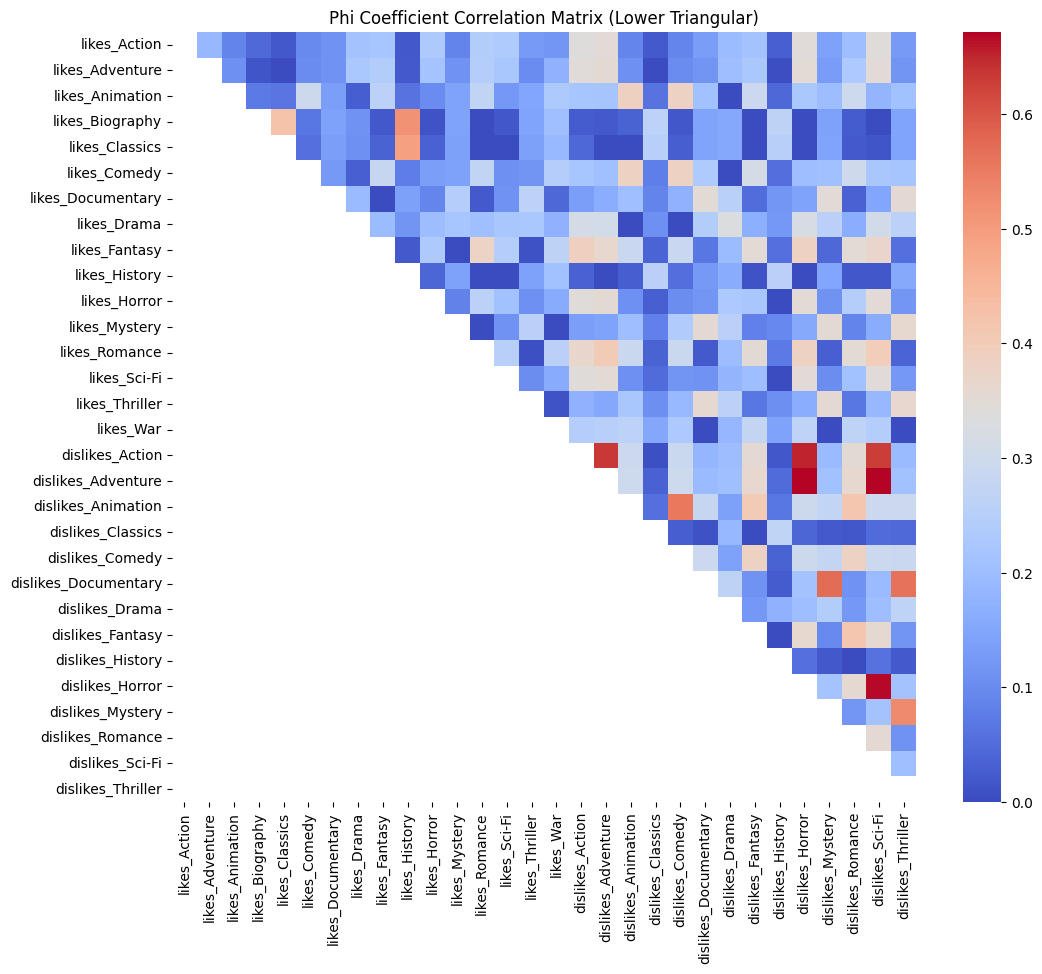

Top 10 correlated pairs (excluding self-correlation):
dislikes_Adventure    dislikes_Horror       0.671828
                      dislikes_Sci-Fi       0.671604
dislikes_Horror       dislikes_Sci-Fi       0.667055
dislikes_Action       dislikes_Horror       0.652602
                      dislikes_Adventure    0.633127
                      dislikes_Sci-Fi       0.628489
dislikes_Documentary  dislikes_Mystery      0.570534
                      dislikes_Thriller     0.564032
dislikes_Animation    dislikes_Comedy       0.556130
dislikes_Mystery      dislikes_Thriller     0.527774
dtype: float64


In [29]:
# Calculate the Phi Coefficient matrix
phi_matrix = phik_matrix(data_matrix)

# Mask the upper triangular part
mask = np.tril(np.ones_like(phi_matrix, dtype=bool))

# Create a heatmap of the lower triangular part
plt.figure(figsize=(12, 10))
sns.heatmap(phi_matrix, mask=mask, cmap='coolwarm')
plt.title('Phi Coefficient Correlation Matrix (Lower Triangular)')
plt.show()

# Apply the mask to the correlation matrix
masked_phi_matrix = phi_matrix.mask(mask)

# Stack the correlation matrix and sort the values
stacked_corr = masked_phi_matrix.stack().sort_values(ascending=False)

# Get the top N highest correlated pairs and their correlation coefficient values
top_N = 10  # Change this value to get a different number of pairs
top_correlated = stacked_corr.head(top_N)

print("Top", top_N, "correlated pairs (excluding self-correlation):")
print(top_correlated)

In [10]:
y = data['cluster']
X = data.drop(columns='cluster')

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

In [12]:
X_train_without_age = X_train.drop(columns=['age'])
X_val_without_age = X_val.drop(columns=['age'])

In [13]:
# Scaling all features excluding 'age'
feat_scaler = MinMaxScaler()
X_train_scaled = feat_scaler.fit_transform(X_train_without_age)
X_val_scaled = feat_scaler.transform(X_val_without_age)

In [41]:
# Perform chi-square test on the scaled dataset
threshold = 15  # Choose the threshold value for the number of top features to select
selector_chi2 = SelectKBest(chi2, k=threshold)
selector_chi2.fit(X_train_scaled, y_train)

# Get the indices of the top features selected by Chi-Square
top_feature_indices_chi2 = selector_chi2.get_support()

# Get the names of the top features selected by Chi-Square from the original X_train columns
names_Chi2 = X_train_without_age.columns[top_feature_indices_chi2]

# Perform MIC test on the scaled dataset
feature_scores_MIC = mutual_info_classif(X_train_scaled, y_train, random_state=0)

# Get the indices of the top features selected by MIC
top_feature_indices_MIC = np.argsort(feature_scores_MIC)[::-1][:threshold]

# Get the names of the top features selected by MIC from the original X_train columns
names_MIC = X_train_without_age.columns[top_feature_indices_MIC]

# Find the intersection of features selected by both tests and exclude 'age'
features_selected = list(set(names_Chi2).intersection(set(names_MIC)))

In [42]:
features_selected

['fav_Tv-shows',
 'dislikes_Adventure',
 'dislikes_Horror',
 'fav_Books',
 'dislikes_Mystery',
 'dislikes_Comedy',
 'dislikes_Action',
 'gender',
 'dislikes_Documentary',
 'dislikes_Drama',
 'dislikes_Sci-Fi',
 'dislikes_Animation',
 'dislikes_Thriller']

In [51]:
#filter data accordingly
X_train_selected_ft = X_train[features_selected + ['age']]
X_val_selected_ft = X_val[features_selected + ['age']] 

In [53]:
X_train_selected_ft = feat_scaler.fit_transform(X_train_selected_ft)
X_val_selected_ft = feat_scaler.transform(X_val_selected_ft)

In [55]:
# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Fit the model on training data with selected features
log_reg.fit(X_train_selected_ft, y_train)

# Make predictions on validation data
predictions = log_reg.predict(X_val_selected_ft)

# Evaluate the model
accuracy = accuracy_score(y_val, predictions)
report = classification_report(y_val, predictions)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9312
Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.99      0.98       554
           2       0.93      0.89      0.91       497
           3       0.91      1.00      0.95       849
           4       0.89      0.72      0.80       277
           5       0.97      0.91      0.94       323

    accuracy                           0.93      2500
   macro avg       0.93      0.90      0.91      2500
weighted avg       0.93      0.93      0.93      2500

